# Chapter 3. Linear Models for Regression

In [12]:
options(warn=-1)
library(arrangements)
library(ggsci)
library(mvtnorm)
library(ggplot2)
library(MASS)
library(gridExtra)
library(limSolve)
library(ramify)

## 3.1 Linear Basis Function Models

In [2]:
PolynomialFeature <- function(X, degree){
        feature <- matrix(rep(1,nrow(X)),nrow(X))
        for (i in 1:degree){
                #i=1
                col.index <- combinations(ncol(X), i,replace = TRUE)
                # print(paste("degree", i, sep=""))
                
                for (j in 1:nrow(col.index)){
                        colcombination = col.index[j,]
                        select.feature = matrix(X[,colcombination],nrow(X))
                        m1 = apply(select.feature,1,prod)
                        feature <- cbind(feature, matrix(m1,nrow(X)))
                        #print(feature)
                        }
        }
        return(feature)
}

GaussianFeature <- function(X, means, variances){
      
        result <- exp(-0.5 / variances * (X-means) ** 2) 
        return(result)
        
}

SigmoidalFeature <- function(X, means, coefs){
        
        result <- tanh((X - means) * coefs * 0.5) * 0.5 + 0.5
        return(result)
        
        
}

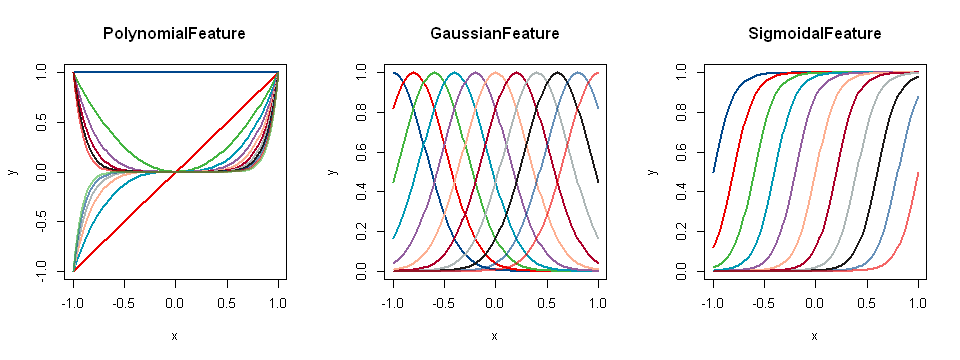

In [3]:
x = seq(-1, 1, length.out = 101)
pal = c(pal_lancet("lanonc")(9),pal_lancet("lanonc", alpha = 0.6)(9))
y = PolynomialFeature(matrix(x),11)[,1]
par(mfrow=c(1,3))
options(repr.plot.width=8,repr.plot.height=3)
plot(x, y, type = "l", main="PolynomialFeature",col = pal[1],
     xlim = c(-1, 1), ylim = c(-1, 1), lwd = 2)

for (i in 2:12){
        y = PolynomialFeature(matrix(x),11)[,i]
        lines(x, y,  type = "l", col = pal[i],  ylab = "",main="PolynomialFeature",lwd = 2)
}

# Guassian Feature

means = seq(-1, 1, length.out = 11)

y = GaussianFeature(x, means[1], variances=0.1)
plot(x, y, type = "l", main="GaussianFeature",col = pal[1],
      xlim = c(-1, 1),  lwd = 2)

for (i in 2:11){
        y = GaussianFeature(x, means[i], variances=0.1)
        lines(x, y,  type = "l",ylab = "",lwd = 2,col = pal[i])
        
}
# SigmoidalFeature 

means = seq(-1, 1, length.out = 11)

y = SigmoidalFeature(x, means[1], coefs=10)
plot(x, y, type = "l", main="SigmoidalFeature",col = pal[1],
     xlim = c(-1, 1),ylim = c(0, 1),  lwd = 2)

for (i in 2:11){
        y = SigmoidalFeature(x, means[i], coefs=10)
        lines(x, y,  type = "l",ylab = "",lwd = 2,col = pal[i])
        
}


## 3.2 The Bias-Variance Decomposition

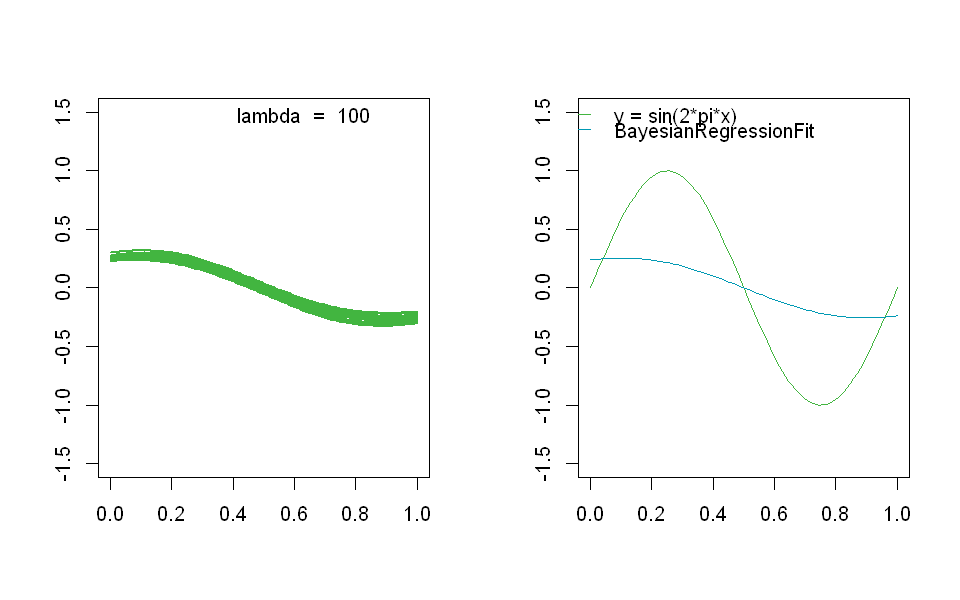

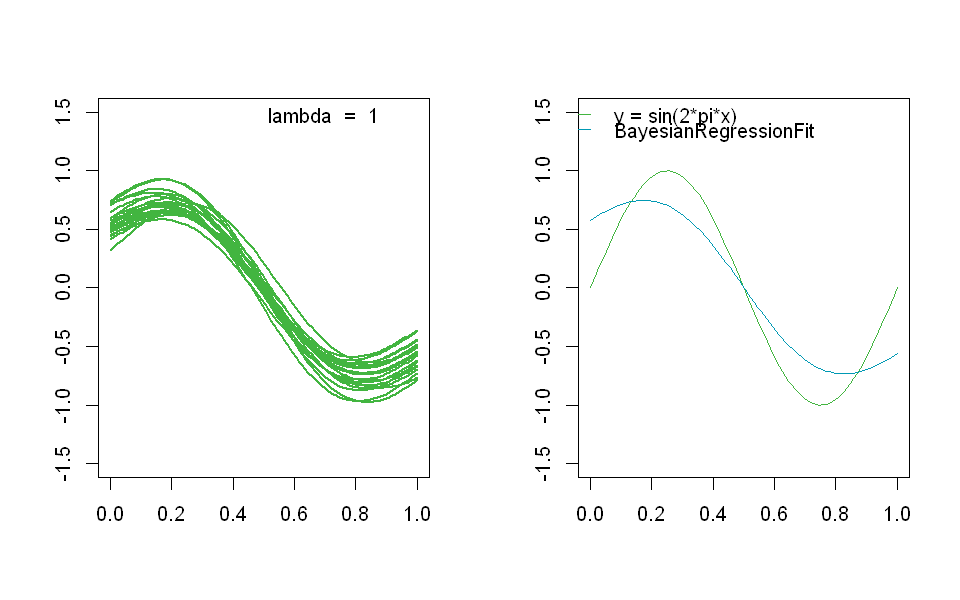

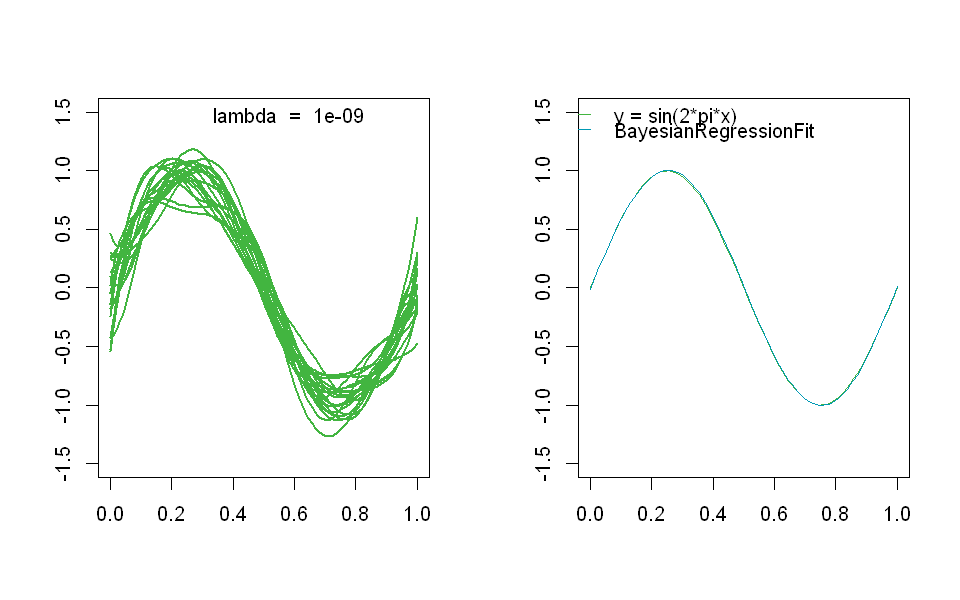

In [4]:
generate_data <- function(func,sample_size,std,lowerbound, upperbound){
        x <- seq(lowerbound, upperbound, length.out = sample_size)
        #x <- sample(x)
        t <- func(x)+rnorm(sample_size,mean = 0, sd = std)
        result <- list("predictor_X"=x, "responser_t"=t)
        return(result)
}

func <- function(x){
        y <- sin(2*pi*x)
        return(y)
}

x_train = generate_data(func, 25, 0.25, 0, 1)$predictor_X
y_train = generate_data(func, 25, 0.25, 0, 1)$responser_t

# Bayesian Regression
is_prior_defined <- function(A,B) {
        return(!is.null(A) & !is.null(B))
}



get_prior <- function(w_mean,w_precision, ndim, alpha) {
        if (is_prior_defined(w_mean,w_precision)){
                result <- list("mean"=w_mean, "precision"=w_precision)
                return(result)
        } else {
                a = rep(0, ndim)
                b = alpha * diag(ndim)
                result <- list("mean"=a, "precision"=b)
                return(result)
        }        
}


BayesianReg_fit <- function(w_mean,w_precision,ndim=ncol(X), alpha, beta, X, t){
        mean_prev = get_prior(w_mean,w_precision, ndim, alpha)$mean
        precision_prev = get_prior(w_mean,w_precision,ndim, alpha)$precision
        
        w_precision = precision_prev + beta * t(X) %*% X
        w_mean = solve(w_precision,
                       precision_prev %*% as.matrix(mean_prev) + beta * t(X) %*% t)
        
        w_cov = solve(w_precision)
        result <- list("w_mean"=w_mean, "w_precision"=w_precision, "w_cov"=w_cov)
        return(result)
}


BayesianReg_predict <- function(X, w_mean, w_cov, beta,sample_size=NA){
        if (is.na(sample_size)){
                y = X %*% w_mean
                y_var = 1 / beta + rowSums(X %*% w_cov * X)
                y_std = sqrt(y_var)
                result <- list("y.pred"=y, "y.std"=y_std)
                return(result)
        } else {
                #samples from the predictive distribution
                w_sample = mvrnorm(n = sample_size, mu =w_mean , Sigma = w_cov)
                y_sample = X %*% t(w_sample)
                return(y_sample)       
                }
}

# initialize parameter
w_mean = NULL
w_precision = NULL

sample_size <- 100
means = seq(0, 1, length.out = 24)
x_test =  seq(0, 1, length.out = 100)

mat = cbind(matrix(0, nrow=25,ncol = 24),matrix(1, nrow=25,ncol = 1))
X_train = array(mat,dim = c(nrow(mat), ncol(mat), 100) )

mat = cbind(matrix(0, nrow=100,ncol = 24),matrix(1, nrow=100,ncol = 1))
X_test = array(mat,dim = c(nrow(mat), ncol(mat), 100) )
for (j in 1:length(means)){
        X_test[,j,i] = GaussianFeature(x_test, means[j], variances=0.1)
}

options(repr.plot.width=8,repr.plot.height=5)

for (a in c(1e2, 1,1e-9)){
        y_mat = matrix(0,nrow=100, ncol=100)
        for (i in 1:100){
                x_train = generate_data(func, 25, 0.25, 0, 1)$predictor_X
                y_train = generate_data(func, 25, 0.25, 0, 1)$responser_t
                x_test =  seq(0, 1, length.out = 100)
                y_test = func(x_test)
                for (j in 1:length(means)){
                        X_train[,j,i] = GaussianFeature(x_train, means[j], variances=0.1)
                }
                for (j in 1:length(means)){
                        X_test[,j,i] = GaussianFeature(x_test, means[j], variances=0.1)
                }
               
                fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 25, alpha=a, beta=1,X_train[,,i], y_train)
                fit.mean <- fit_result$w_mean
                fit.precision <- fit_result$w_precision
                fit.cov <- fit_result$w_cov

                pred_result <- BayesianReg_predict(X_test[,,i], fit.mean, fit.cov, beta=1,sample_size=NA)
                y_mat[,i] <- pred_result$y.pred
        }
        
        par(mfrow=c(1,2))
        plot(x_test,y_mat[,1],col = pal[3], lwd = 2 ,type = "l", ylim = c(-1.5, 1.5),xlab="", ylab="")
        for (i in 2:20){
                lines(x_test, y_mat[,i],  type = "l", col = pal[3], lwd = 2)
        }
        legend("topright", legend = paste(expression(lambda), " = ", a), bty = "n")
        
        
        
        plot(x_test, y_test, type = "l",col = pal[3], ylim = c(-1.5, 1.5),xlab="", ylab="")
        lines(x_test, matrix(rowMeans(y_mat), nrow = 100), type = "l",col = pal[4])
        legend("topright", col = c(pal[3],pal[4]), 
               legend = c("y = sin(2*pi*x)", "BayesianRegressionFit"),lty = c( 1, 1),bty = "n")
}



## 3.3 Bayesian Linear Regression

### 3.3.1 Parameter distribution

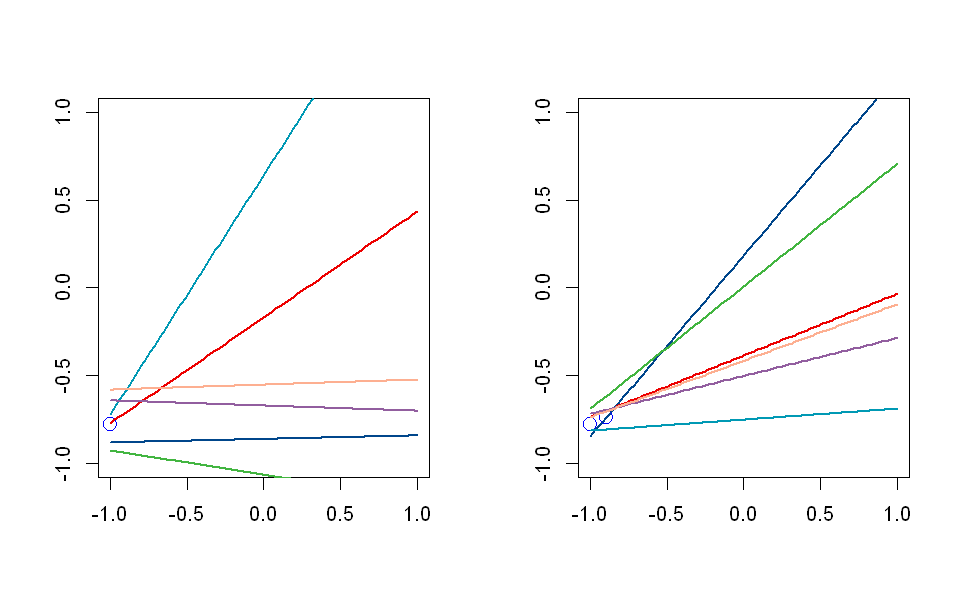

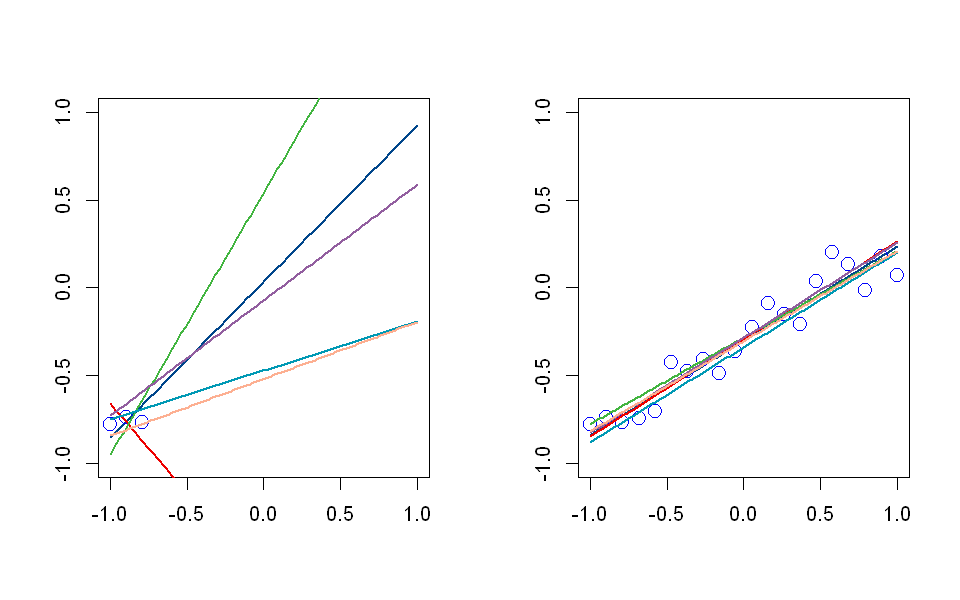

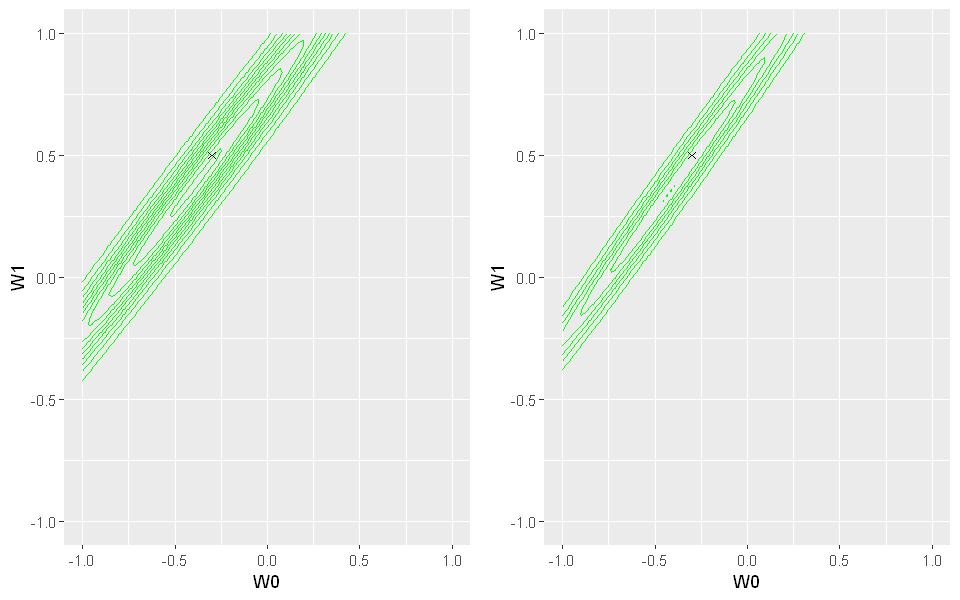

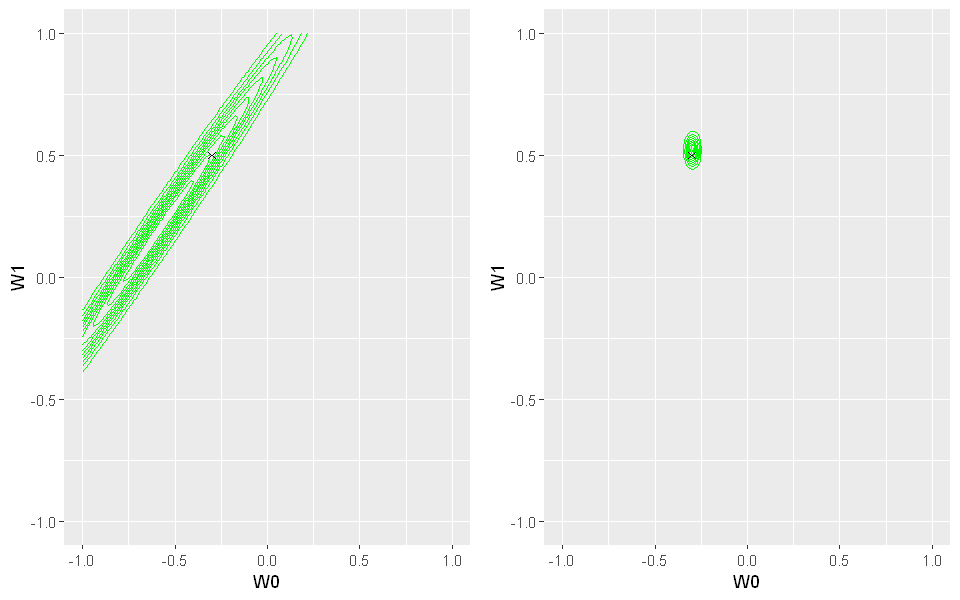

In [5]:
par(mfrow=c(1,2))
linear <- function(X){
        -0.3 + 0.5 * X
}

x_train = generate_data(linear , 20, 0.1, -1, 1)$predictor_X
y_train = generate_data(linear , 20, 0.1, -1, 1)$responser_t
true_para = data.frame(matrix(c(-0.3,0.5),1))
x = seq(-1, 1, length.out = 100)


X_train = PolynomialFeature(matrix(x_train),1)
X = PolynomialFeature(matrix(x),1)


data.grid <- expand.grid(s.1 = seq(-1, 1, length.out=100), 
                         s.2 = seq(-1, 1, length.out=100))



i=1
w_mean = NULL
w_precision = NULL
fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 2, alpha=1, 
                             beta=100,matrix(X_train[i,],nrow = 1), y_train[i])
w_mean <- fit_result$w_mean
w_precision <- fit_result$w_precision
w_cov <- fit_result$w_cov

q3.samp = cbind(data.grid, prob = dmvnorm(data.grid, mean = w_mean, sigma=w_cov))
plot1 = ggplot(data.frame(true_para), aes(x=X1, y=X2))+
        ylim(-1, 1) + xlim(-1, 1)+ labs(x = "W0",y="W1")+
        geom_contour(data=q3.samp,aes(x=s.1,y=s.2,z=prob),col="green")+
        geom_point(shape=4)

t = BayesianReg_predict(X, w_mean, w_cov, beta,sample_size=6)

plot(x,t[,1],col = pal[1], lwd = 2 ,type = "l", ylim = c(-1, 1),xlim = c(-1, 1),xlab="", ylab="")
points(X_train[1:i,2], y_train[1:i], col = "blue", cex = 1.5)
for (i in 2:6){
        lines(x,t[,i],  type = "l", col = pal[i], lwd = 2)
}

#
i=2

fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 2, alpha=1, 
                             beta=100,matrix(X_train[i,],nrow = 1), y_train[i])
w_mean <- fit_result$w_mean
w_precision <- fit_result$w_precision
w_cov <- fit_result$w_cov

q3.samp = cbind(data.grid, prob = dmvnorm(data.grid, mean = w_mean, sigma=w_cov))
plot2 = ggplot(data.frame(true_para), aes(x=X1, y=X2))+
        ylim(-1, 1) + xlim(-1, 1)+ labs(x = "W0",y="W1")+
        geom_contour(data=q3.samp,aes(x=s.1,y=s.2,z=prob),col="green")+
        geom_point(shape=4)
t = BayesianReg_predict(X, w_mean, w_cov, beta,sample_size=6)

plot(x,t[,1],col = pal[1], lwd = 2 ,type = "l", ylim = c(-1, 1),xlim = c(-1, 1),xlab="", ylab="")
points(X_train[1:i,2], y_train[1:i], col = "blue", cex = 1.5)
for (i in 2:6){
        lines(x,t[,i],  type = "l", col = pal[i], lwd = 2)
}


#
i=3

fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 2, alpha=1, 
                             beta=100,matrix(X_train[i,],nrow = 1), y_train[i])
w_mean <- fit_result$w_mean
w_precision <- fit_result$w_precision
w_cov <- fit_result$w_cov

q3.samp = cbind(data.grid, prob = dmvnorm(data.grid, mean = w_mean, sigma=w_cov))
plot3 = ggplot(data.frame(true_para), aes(x=X1, y=X2))+
        ylim(-1, 1) + xlim(-1, 1)+ labs(x = "W0",y="W1")+
        geom_contour(data=q3.samp,aes(x=s.1,y=s.2,z=prob),col="green")+
        geom_point(shape=4)

t = BayesianReg_predict(X, w_mean, w_cov, beta,sample_size=6)
plot(x,t[,1],col = pal[1], lwd = 2 ,type = "l", ylim = c(-1, 1),xlim = c(-1, 1),xlab="", ylab="")
points(X_train[1:i,2], y_train[1:i], col = "blue", cex = 1.5)
for (i in 2:6){
        lines(x,t[,i],  type = "l", col = pal[i], lwd = 2)
}

##################
for (i in 4:20){
        fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 2, alpha=1, 
                                     beta=100,matrix(X_train[i,],nrow = 1), y_train[i])
        w_mean <- fit_result$w_mean
        w_precision <- fit_result$w_precision
        w_cov <- fit_result$w_cov
        
        q3.samp = cbind(data.grid, prob = dmvnorm(data.grid, mean = w_mean, sigma=w_cov))
        
}

plot4 =ggplot(data.frame(true_para), aes(x=X1, y=X2))+
        ylim(-1, 1) + xlim(-1, 1)+ labs(x = "W0",y="W1")+
        geom_contour(data=q3.samp,aes(x=s.1,y=s.2,z=prob),col="green")+
        geom_point(shape=4)

t = BayesianReg_predict(X, w_mean, w_cov, beta,sample_size=6)

plot(x,t[,1],col = pal[1], lwd = 2 ,type = "l", ylim = c(-1, 1),xlim = c(-1, 1),xlab="", ylab="")
points(X_train[1:i,2], y_train[1:i], col = "blue", cex = 1.5)
for (i in 2:6){
        lines(x,t[,i],  type = "l", col = pal[i], lwd = 2)
}

grid.arrange(plot1, plot2, ncol=2)
grid.arrange(plot3, plot4, ncol=2)

### 3.3.2 Predictive distribution

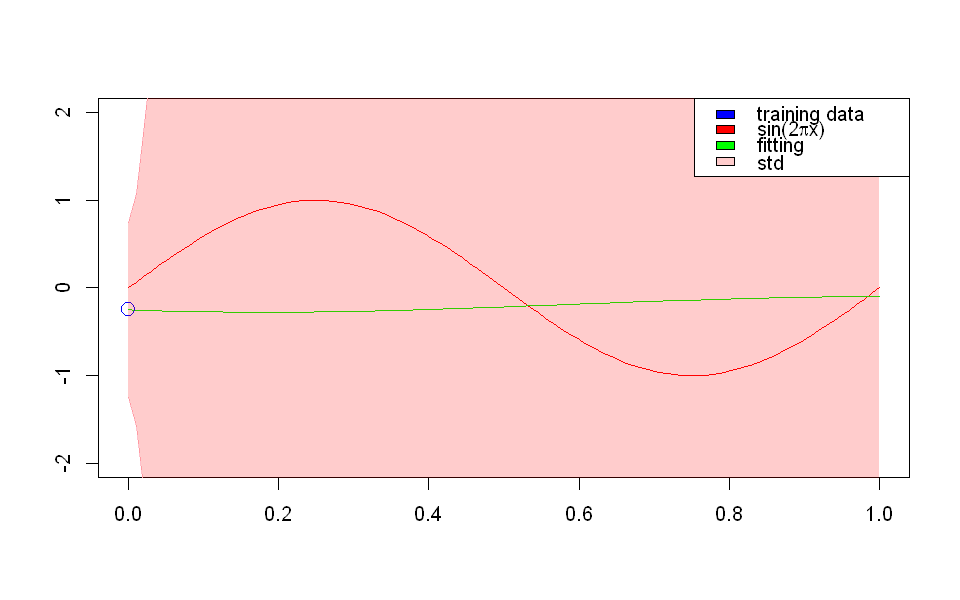

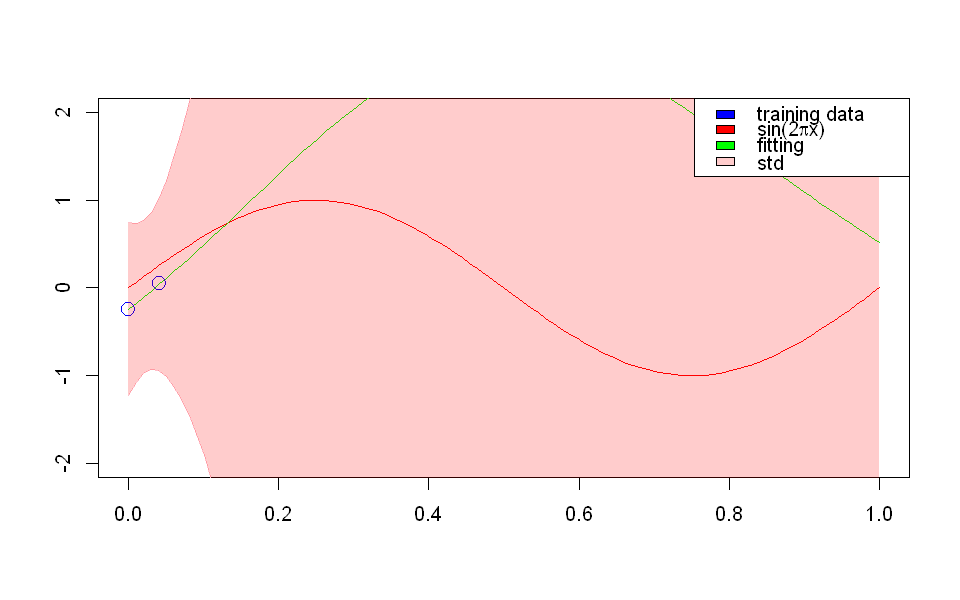

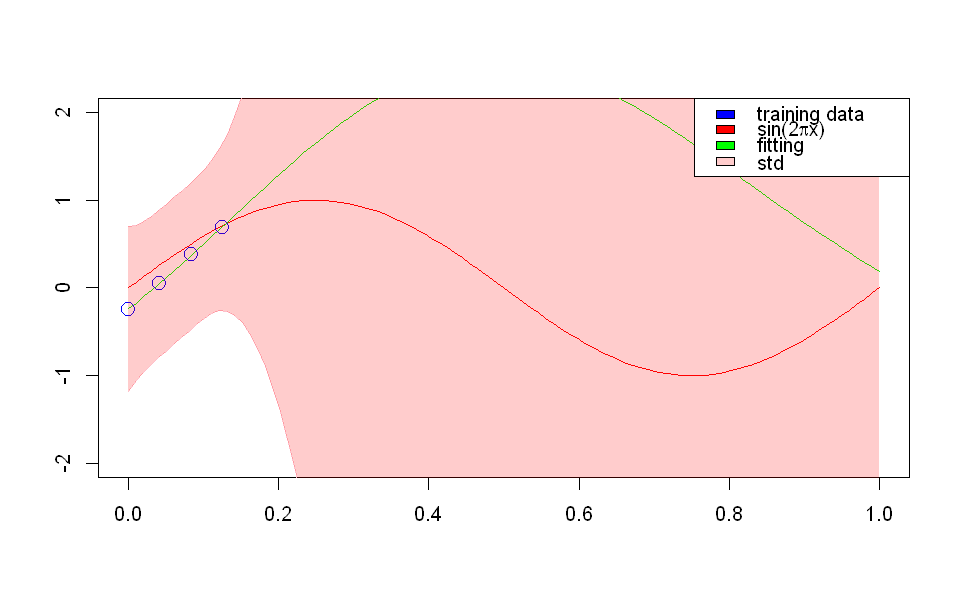

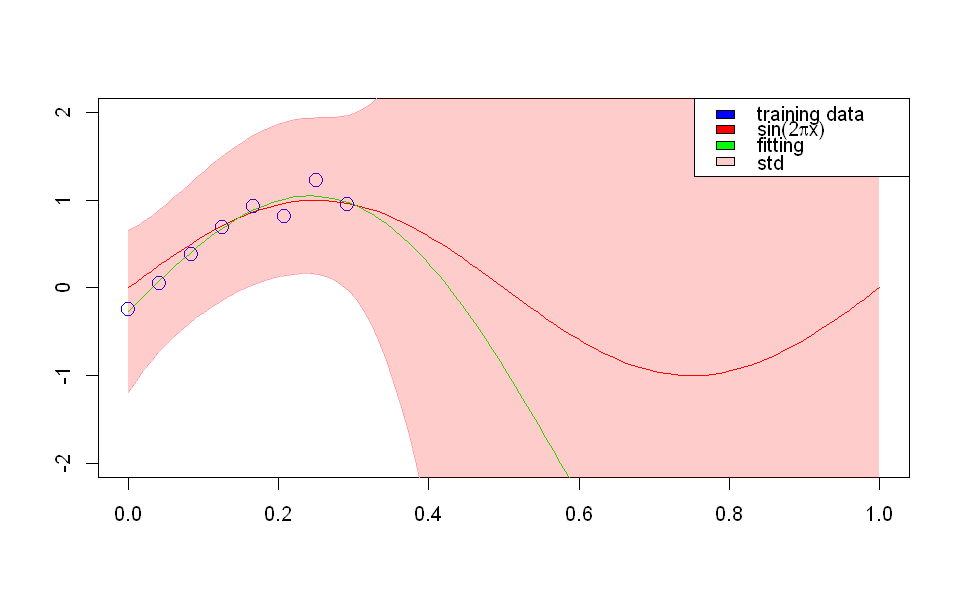

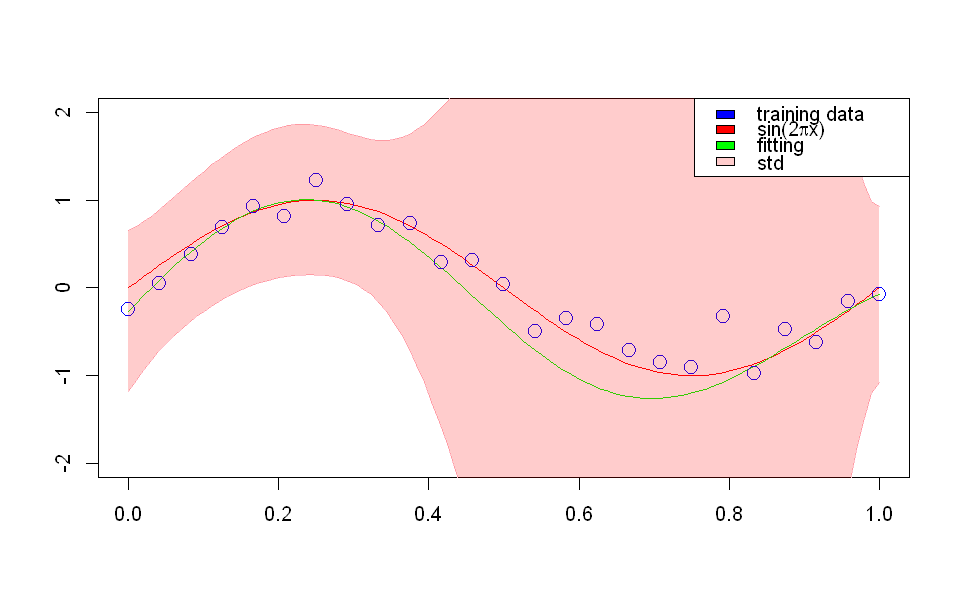

In [6]:
# create data 
x_train = generate_data(func , 25, 0.25, 0, 1)$predictor_X
y_train = generate_data(func , 25, 0.25, 0, 1)$responser_t
x_test =  seq(0, 1, length.out = 100)
y_test = func(x_test)
means = seq(0, 1, length.out = 9)

X_train= cbind(matrix(0, nrow=25,ncol = 9),matrix(1, nrow=25,ncol = 1))
X_test = cbind(matrix(0, nrow=100,ncol = 9),matrix(1, nrow=100,ncol = 1))
for (j in 1:length(means)){
        X_train[,j] = GaussianFeature(x_train, means[j], variances=0.1)
}

for (j in 1:length(means)){
        X_test[,j] = GaussianFeature(x_test, means[j], variances=0.1)
}


#  
w_mean = NULL
w_precision = NULL
fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 10, alpha=1e-3, beta=2, matrix(X_train[1,],1), y_train[1])
w_mean <- fit_result$w_mean
w_precision <- fit_result$w_precision
w_cov <- fit_result$w_cov
 
# (X, w_mean, w_cov, beta,sample_size=NA)  model.predict(X_test, return_std=True)
pred_result <- BayesianReg_predict(X_test, w_mean, w_cov, beta=2,sample_size=NA)
y <- pred_result$y.pred
y_std <- pred_result$y.std

plot(x_test, y_test,
     type="l", col="red", xlab="", ylab="", xlim = c(0,1), ylim = c(-2,2))
lines(x_test,y, col="green")
points(x_train[1], y_train[1], col = "blue", cex = 1.5)

lines(x_test,y - y_std, col="pink")
lines(x_test,y + y_std, col="pink")
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))



#  
i=2

fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 10, alpha=1e-3, beta=2, matrix(X_train[i,],1), y_train[i])
w_mean <- fit_result$w_mean
w_precision <- fit_result$w_precision
w_cov <- fit_result$w_cov

# (X, w_mean, w_cov, beta,sample_size=NA)  model.predict(X_test, return_std=True)
pred_result <- BayesianReg_predict(X_test, w_mean, w_cov, beta=2,sample_size=NA)
y <- pred_result$y.pred
y_std <- pred_result$y.std


plot(x_test, y_test,
     type="l", col="red", xlab="", ylab="", xlim = c(0,1), ylim = c(-2,2))
lines(x_test,y, col="green")
points(x_train[1:i], y_train[1:i], col = "blue", cex = 1.5)

lines(x_test,y - y_std, col="pink")
lines(x_test,y + y_std, col="pink")
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))


###
for (i in c(3,4)){
  
  fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 10, alpha=1e-3, beta=2, matrix(X_train[i,],1), y_train[i])
  w_mean <- fit_result$w_mean
  w_precision <- fit_result$w_precision
  w_cov <- fit_result$w_cov
  
  # (X, w_mean, w_cov, beta,sample_size=NA)  model.predict(X_test, return_std=True)
  pred_result <- BayesianReg_predict(X_test, w_mean, w_cov, beta=2,sample_size=NA)
  y <- pred_result$y.pred
  y_std <- pred_result$y.std
}

plot(x_test, y_test,
     type="l", col="red", xlab="", ylab="", xlim = c(0,1), ylim = c(-2,2))
lines(x_test,y, col="green")
points(x_train[1:i], y_train[1:i], col = "blue", cex = 1.5)

lines(x_test,y - y_std, col="pink")
lines(x_test,y + y_std, col="pink")
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))


##

for (i in c(5,8)){
  
  fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 10, alpha=1e-3, beta=2, matrix(X_train[i,],1), y_train[i])
  w_mean <- fit_result$w_mean
  w_precision <- fit_result$w_precision
  w_cov <- fit_result$w_cov
  
  # (X, w_mean, w_cov, beta,sample_size=NA)  model.predict(X_test, return_std=True)
  pred_result <- BayesianReg_predict(X_test, w_mean, w_cov, beta=2,sample_size=NA)
  y <- pred_result$y.pred
  y_std <- pred_result$y.std
}

plot(x_test, y_test,
     type="l", col="red", xlab="", ylab="", xlim = c(0,1), ylim = c(-2,2))
lines(x_test,y, col="green")
points(x_train[1:i], y_train[1:i], col = "blue", cex = 1.5)

lines(x_test,y - y_std, col="pink")
lines(x_test,y + y_std, col="pink")
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))

#
for (i in c(9,25)){
  
  fit_result = BayesianReg_fit(w_mean,w_precision,ndim= 10, alpha=1e-3, beta=2, matrix(X_train[i,],1), y_train[i])
  w_mean <- fit_result$w_mean
  w_precision <- fit_result$w_precision
  w_cov <- fit_result$w_cov
  
  # (X, w_mean, w_cov, beta,sample_size=NA)  model.predict(X_test, return_std=True)
  pred_result <- BayesianReg_predict(X_test, w_mean, w_cov, beta=2,sample_size=NA)
  y <- pred_result$y.pred
  y_std <- pred_result$y.std
}

plot(x_test, y_test,
     type="l", col="red", xlab="", ylab="", xlim = c(0,1), ylim = c(-2,2))
lines(x_test,y, col="green")
points(x_train[1:i], y_train[1:i], col = "blue", cex = 1.5)

lines(x_test,y - y_std, col="pink")
lines(x_test,y + y_std, col="pink")
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))



## 3.5 The Evidence Approximation

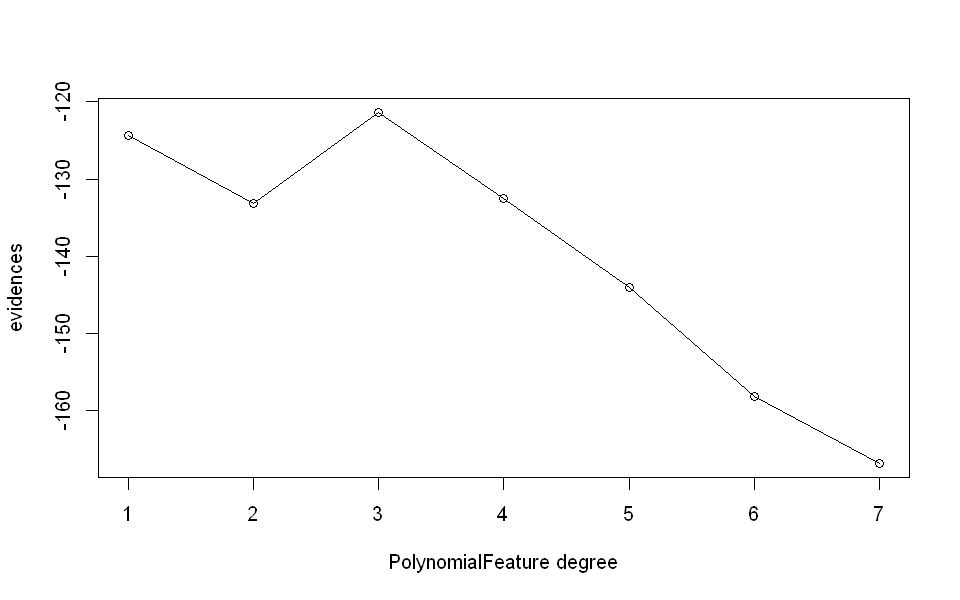

In [16]:
EmpiricalBayesRegression <- function(X, t, alpha, beta, max_iter ){
  M = t(X) %*% X
  eigenvalues = eigen(M, only.values = T)$values
  eye = diag(ncol(X))
  N = length(t)
  for (i in 1:max_iter){
    w_precision = alpha * eye + beta * t(X) %*% X
    w_mean = beta * Solve(w_precision, t(X) %*% t)
    
    gamma = sum(eigenvalues / (alpha + eigenvalues))
    alpha1 = gamma / clip(sum(w_mean ** 2), .min = 1e-10)
    clip(sum(w_mean ** 2), .min = 1e-10)
    beta1 = (N - gamma) / sum((t - X %*% w_mean)^2)
    diff1 <- alpha1 - alpha
    diff2 <- beta1 - beta
    allclose <- (diff1 < 0.00001) & (diff2 < 0.00001)
    alpha <- alpha1
    beta <- beta1
    
    if (allclose) break
  }
  w_mean = w_mean
  w_precision = w_precision
  w_cov = solve(w_precision)
  result <- list("w_mean"= w_mean, "w_precision" = w_precision, "w_cov" = w_cov, 
                 "alpha"= alpha, "beta"=beta)
  return(result)
  
  
}


log_evidence <- function(X, t,alpha,beta,w_mean, w_precision){
  
  N = length(t)
  D = ncol(X)
  log_likelihood = -0.5 * beta * sum((t - X %*% w_mean)^2)
  log_prior = -0.5 * alpha * sum(w_mean ** 2)
  log_posterior = log_likelihood + log_prior
  
  return (0.5 * ( D * log(alpha) + N * log(beta)
                  - determinant(w_precision, logarithm = TRUE)$modulus - D * log(2 * pi)) + log_posterior)
}


# generate data
cubic <- function(x){
  return (x * (x - 5) * (x + 5))
}

x_train = generate_data(cubic, 30, 10,-5, 5)$predictor_X
y_train = generate_data(cubic, 30, 10,-5, 5)$responser_t
x_test =  seq(-5, 5, length.out = 100)
evidences = c()
models = c()

for (i in 1:7){
  
  X_train = PolynomialFeature(matrix(x_train), degree=i)
  # X, t, alpha, beta, max_iter
  EmpBayes_fit = EmpiricalBayesRegression(X_train, y_train, alpha=100, beta=100,max_iter=100)
  lg = log_evidence(X_train, y_train,EmpBayes_fit$alpha,
                    EmpBayes_fit$beta,EmpBayes_fit$w_mean, EmpBayes_fit$w_precision)
  evidences = c(evidences,lg)
  
}

par(mfrow=c(1,1))
plot(evidences,type="o", xlab= "PolynomialFeature degree")

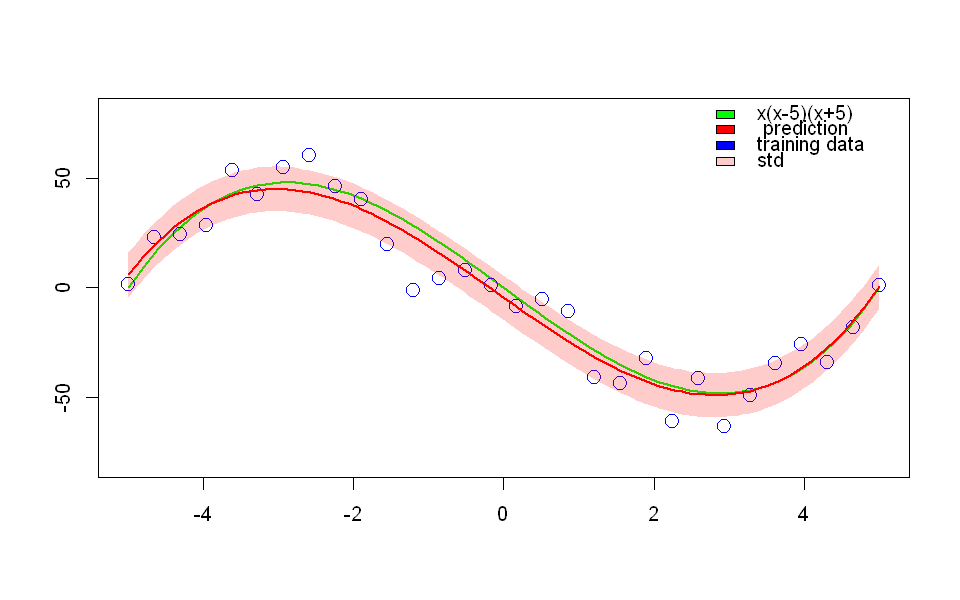

In [18]:

i = which.max(evidences)
X_train = PolynomialFeature(matrix(x_train), degree=i)
EmpBayes_fit = EmpiricalBayesRegression(X_train, y_train, alpha=100, beta=100,max_iter=100)
X_test = PolynomialFeature(matrix(x_test), degree=i)
pred_result <- BayesianReg_predict(X_test, EmpBayes_fit$w_mean, 
                                   EmpBayes_fit$w_cov, beta=EmpBayes_fit$beta)
y <- pred_result$y.pred
y_std <- pred_result$y.std


plot(x_test, cubic(x_test),col = "green", lwd = 2 ,type = "l", 
     ylim = c(-80, 80),xlim = c(-5, 5),xlab="", ylab="") # x(x-5)(x+5)
points(x_train, y_train, col = "blue", cex = 1.5)

lines(x_test, y,  type = "l", col = "red", lwd = 2) # prediction
x=x_test
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright", bty = "n",
       c("x(x-5)(x+5)"," prediction","training data","std"),
       fill=c("green","red","blue",rgb(1, 0, 0,0.2)))